In [3]:
from astropy.time import Time
import astropy.units as u
import astropy.coordinates as coord
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from twobody import KeplerOrbit, Barycenter
# from thejoker import RVData

Make some fake data:

In [4]:
t0 = Time(58425.134, format='mjd')
K = 13.013 * u.km/u.s
orbit = KeplerOrbit(P=110*u.day, e=0.4, M0=0.52*u.radian, omega=1.6*u.radian, 
                    Omega=0*u.deg, i=90*u.deg, t0=t0)

In [5]:
rnd = np.random.RandomState(seed=1234)
t = t0 + rnd.uniform(0, 3, size=8) * u.year
t = t.sort()

rv = K * orbit.unscaled_radial_velocity(t)
rv_err = np.ones(len(rv)) * 0.5 * u.km/u.s
rv = rnd.normal(rv, rv_err.to(rv.unit)) * rv.unit

# data = RVData(t=t, rv=rv, stddev=rv_err)
# _ = data.plot()

Text(0,0.5,'unscaled radial velocity')

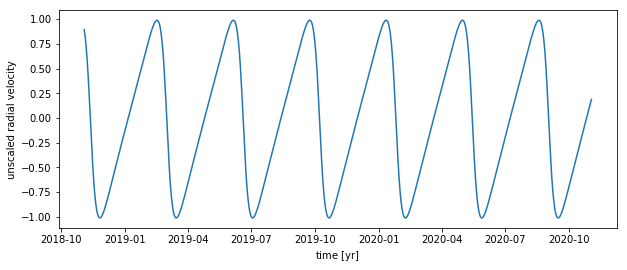

In [6]:
# If we don't specify K or a, then the absolute RV variation is unknown

t = t0 + np.linspace(0,2,1024) * u.year

unscaled_rv = orbit.unscaled_radial_velocity(t)

fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(t.datetime, unscaled_rv, marker='')
ax.set_xlabel('time [{0:latex_inline}]'.format(u.year)) 
ax.set_ylabel('unscaled radial velocity') 


Text(0,0.5,'radial velocity [$\\mathrm{km\\,s^{-1}}$]')

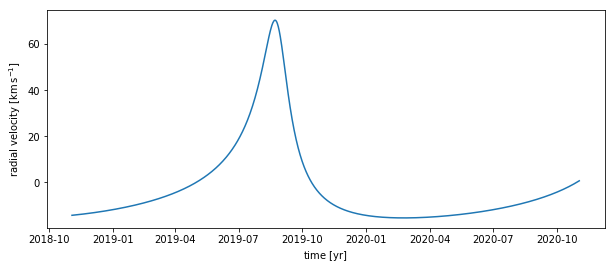

In [7]:
# We have to specify the semi-major axis to produce a real velocity amplitude
# But these are still computed relative to the barycenter/reference point of the orbit

orb = KeplerOrbit(P=1.5*u.year, e=0.67, a=1.77*u.au,
                  omega=17.14*u.deg, i=65*u.deg, Omega=0*u.deg,
                  M0=35.824*u.deg, t0=Time('J2015.0'))
rv = orb.radial_velocity(t)

fig,ax = plt.subplots(1, 1,figsize=(10,4)) 
ax.plot(t.datetime, rv.to(u.km/u.s).value, marker='') 
ax.set_xlabel('time [{0:latex_inline}]'.format(u.year)) 
ax.set_ylabel('radial velocity [{0:latex_inline}]'.format(u.km/u.s)) 

Text(0,0.5,'radial velocity [$\\mathrm{km\\,s^{-1}}$]')

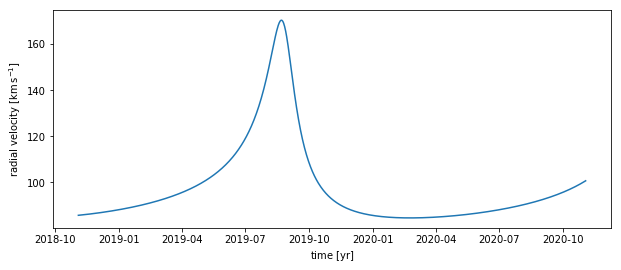

In [8]:
# Need to also add the barycentric or systematic velocity of the system 
# to get real line-of-sight velocities

v0 = 100 * u.km/u.s
fig,ax = plt.subplots(1, 1,figsize=(10,4)) 
ax.plot(t.datetime, (rv + v0).to(u.km/u.s).value, marker='') 
ax.set_xlabel('time [{0:latex_inline}]'.format(u.year)) 
ax.set_ylabel('radial velocity [{0:latex_inline}]'.format(u.km/u.s)) 

In [9]:
# For sources with appreciable tangential motion over the timescale of observations, 
# There are additional effects due to spherical projection

# Plot the orbit from various perspectives

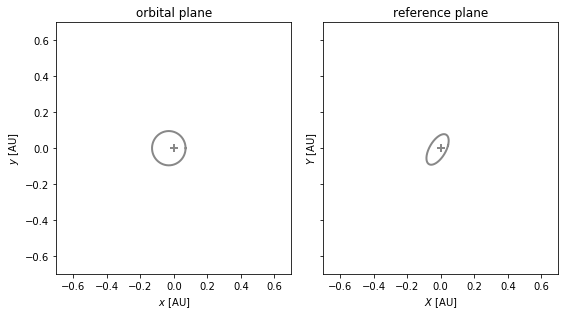

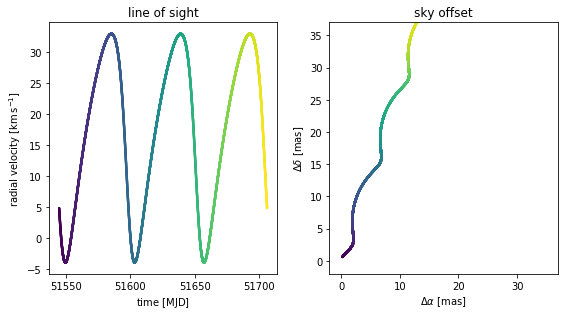

In [10]:
origin = coord.ICRS(ra=14.745*u.deg, dec=71.512*u.deg,
                    distance=71.634*u.pc,
                    pm_ra_cosdec=32.123*u.mas/u.yr,
                    pm_dec=86.63*u.mas/u.yr,
                    radial_velocity=17.4123*u.km/u.s)
b = Barycenter(origin=origin, t0=Time('J2000'))

orb = KeplerOrbit(P=54*u.day, a=0.1*u.au, e=0.3,
                  omega=2.124*u.rad, M0=0*u.rad, t0=Time('J2000'),
                  Omega=121.53*u.deg, i=61*u.deg,
                  barycenter=b)

t1 = Time('J2000') + np.linspace(0, orb.P.to(u.day).value, 10000)*u.day
xyz = orb.orbital_plane(t1)
XYZ = orb.reference_plane(t1).cartesian

orbit_style = dict(marker='', linestyle='-', linewidth=2, color='#888888')
body_style = dict(marker='o', linestyle='none', color='tab:red',
                  markersize=12, zorder=100)
barycen_style = dict(marker='+', color='#888888', mew=2, ms=8)

fig, axes = plt.subplots(1, 2, figsize=(8,4.5),
                         sharex=True, sharey=True)

axes[0].plot(xyz.x, xyz.y, **orbit_style)
axes[0].plot(0, 0, **barycen_style)

axes[1].plot(XYZ.x, XYZ.y, **orbit_style)
axes[1].plot(0, 0, **barycen_style)

lim = 0.7
for j in [0, 1]:
    axes[j].set_xlim(-lim, lim)
    axes[j].set_ylim(-lim, lim)


axes[0].set_xlabel('$x$ [{0:latex_inline}]'.format(xyz.x.unit))
axes[0].set_ylabel('$y$ [{0:latex_inline}]'.format(xyz.x.unit))

axes[1].set_xlabel('$X$ [{0:latex_inline}]'.format(xyz.x.unit))
axes[1].set_ylabel('$Y$ [{0:latex_inline}]'.format(xyz.x.unit))

axes[0].set_title('orbital plane')
axes[1].set_title('reference plane')

fig.tight_layout()

# --------------------
# plot 2

t2 = Time('J2000') + np.linspace(0, 3*orb.P.value, 10000)*orb.P.unit
icrs = orb.icrs(t2)
# TODO: this is only necessary because the released version of Astropy
# doesn't support velocity transforms in SkyOffsetFrame
_icrs = coord.ICRS(icrs.spherical.without_differentials())
_origin = coord.ICRS(origin.spherical.without_differentials())
offset = _icrs.transform_to(coord.SkyOffsetFrame(origin=_origin))
# offset = icrs.transform_to(coord.SkyOffsetFrame(origin=origin))

style = dict(marker='o', s=2, cmap='viridis')

fig, axes = plt.subplots(1, 2, figsize=(8, 4.5))

axes[0].scatter(t2.mjd, icrs.radial_velocity,
                c=t2.mjd, **style)
axes[0].set_xlabel(r'time [${\rm MJD}$]')
axes[0].set_ylabel(r'radial velocity [{0:latex_inline}]'
                   .format(icrs.radial_velocity.unit))
axes[0].set_title('line of sight')

axes[1].scatter(offset.lon.wrap_at(180*u.deg).milliarcsecond,
                offset.lat.milliarcsecond,
                c=t2.mjd, **style)
axes[1].set_xlabel(r'$\Delta\alpha$ [{0:latex_inline}]'.format(u.mas))
axes[1].set_ylabel(r'$\Delta\delta$ [{0:latex_inline}]'.format(u.mas))
axes[1].set_title('sky offset')
axes[1].set_xlim(-2, 37)
axes[1].set_ylim(-2, 37)

fig.tight_layout()

In [19]:
def plot_orbit(origin, orb, nsteps, filebase="planet_ref",
               reference=True):
    
    if nsteps<100:
        ntimes = nsteps * 100
    else:
        ntimes = nsteps
    print(ntimes, nsteps)
        
    steps = np.arange(0,ntimes,ntimes//nsteps)
    
    t1 = Time('J2000') + np.linspace(0, orb.P.to(u.day).value, ntimes)*u.day
    xyz = orb.orbital_plane(t1)
    XYZ = orb.reference_plane(t1).cartesian

    body_style = dict(marker='o', linestyle='none', color='k',
                      markersize=10, zorder=100)
    barycen_style = dict(marker='+', color='#888888', mew=2, ms=8)
    style = dict(marker='o', s=2, cmap='magma',zorder=10,vmax=t1.mjd[-1],vmin=t1.mjd[0])
    print(style["vmax"],style["vmin"])
    icrs = orb.icrs(t1)
    
#     if reference is True:
#         xmin0, xmax0 = min(XYZ.x.value), max(XYZ.x.value)
#         ymin0, ymax0 = min(XYZ.y.value), max(XYZ.y.value)
        
#     else:
#         xmin0, xmax0 = min(xyz.x.value), max(xyz.x.value)
#         ymin0, ymax0 = min(xyz.y.value), max(xyz.y.value)
#     print(xmin0,xmax0,ymin0,ymax0)
    xmin0, xmax0, ymin0, ymax0 = -0.2,0.2,-0.2,0.2

    xmin1, xmax1 = min(t1.mjd), max(t1.mjd)
    ymin1, ymax1 = min(icrs.radial_velocity.value), max(icrs.radial_velocity.value)
    print(xmin1,xmax1,ymin1,ymax1)

    # Now plot
    for i,idx in enumerate(steps):
        fig, axes = plt.subplots(1, 2, figsize=(8,4.5))

        axes[0].plot(0, 0, **barycen_style)

        if reference is False:
            axes[0].scatter(xyz.x[:idx], xyz.y[:idx],
                            c=t1.mjd[:idx], **style)
            axes[0].plot(xyz.x[idx],xyz.y[idx],**body_style)

            axes[0].set_xlabel('$x$ [{0:latex_inline}]'.format(xyz.x.unit))
            axes[0].set_ylabel('$y$ [{0:latex_inline}]'.format(xyz.y.unit))

            axes[0].set_title('orbital plane')
            
        else:
            axes[0].scatter(XYZ.x[:idx], XYZ.y[:idx],
                            c=t1.mjd[:idx], **style)
            axes[0].plot(XYZ.x[idx],XYZ.y[idx],**body_style)
            print(idx,XYZ.x[idx],XYZ.y[idx])
            axes[0].set_xlabel('$X$ [{0:latex_inline}]'.format(XYZ.x.unit))
            axes[0].set_ylabel('$Y$ [{0:latex_inline}]'.format(XYZ.y.unit))

            axes[0].set_title('reference plane')
        
        axes[0].set_xlim(xmin0,xmax0)
        axes[0].set_ylim(ymin0,ymax0)        


        axes[1].scatter(t1.mjd[:idx], icrs.radial_velocity[:idx],
                       c=t1.mjd[:idx], **style)
        axes[1].set_xlabel(r'time [${\rm MJD}$]')
        axes[1].set_ylabel(r'radial velocity [{0:latex_inline}]'
                          .format(icrs.radial_velocity.unit))
        axes[1].set_title('line of sight')
        axes[1].set_xlim(xmin1,xmax1)
        axes[1].set_ylim(ymin1,ymax1)     
        
        plt.savefig("figures/{0}_{1:0>3}.png".format(filebase,i+1),dpi=600,
                    bbox_inches="tight")

        plt.close()

In [21]:
origin = coord.ICRS(ra=14.745*u.deg, dec=71.512*u.deg,
                    distance=71.634*u.pc,
                    pm_ra_cosdec=32.123*u.mas/u.yr,
                    pm_dec=86.63*u.mas/u.yr,
                    radial_velocity=17.4123*u.km/u.s)
b = Barycenter(origin=origin, t0=Time('J2000'))

orb = KeplerOrbit(P=54*u.day, a=0.1*u.au, e=0.3,
                  omega=2.124*u.rad, M0=0*u.rad, t0=Time('J2000'),
                  Omega=121.53*u.deg, i=61*u.deg,
                  barycenter=b)

plot_orbit(origin,orb,100,reference=True,filebase="planet_ref")

100 100
51598.5 51544.5
51544.5 51598.5 -3.9700243131121353 32.96660156792009
0 0.043845416627195925 AU 0.0162493066467039 AU
1 0.045555062721469655 AU 0.023564246423098466 AU
2 0.04673354900901232 AU 0.030604564560904674 AU
3 0.04737555204620632 AU 0.037293801727043774 AU
4 0.04748731841211956 AU 0.04356598720844218 AU
5 0.047085561673662235 AU 0.04936748585490932 AU
6 0.04619578561687013 AU 0.054657812381710164 AU
7 0.044850288306048036 AU 0.05940948986463301 AU
8 0.04308609508952619 AU 0.06360714436720834 AU
9 0.040943020374028055 AU 0.06724608159138558 AU
10 0.03846199015209538 AU 0.07033058984479552 AU
11 0.03568368981455251 AU 0.07287217476917007 AU
12 0.03264754737796473 AU 0.07488787545917935 AU
13 0.029391025599756284 AU 0.07639875516636434 AU
14 0.02594917663690563 AU 0.0774286122524944 AU
15 0.02235440608365154 AU 0.07800292216670837 AU
16 0.018636394906949044 AU 0.07814799868466159 AU
17 0.014822134152332397 AU 0.07789035020200949 AU
18 0.010936035425799677 AU 0.07725620172